In this notebook, we will look at a few different ways of visualizing the chemical space covered by a set of molecules. We will cover principal component anlaysis (PCA) and t-distributed stochastic neighbor embedding (t-sne)

We will start by importing a the necessary Python libraries

To do next: add variance explained by each component to the principal components plots. Change perplexity and number of steps for t-SNE plots.

In [15]:
import pandas as pd
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import MACCSkeys
from rdkit.Avalon import pyAvalonTools
from rdkit.Chem import rdMolDescriptors
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

We set a few parameters to improve the appearance of our plots

In [3]:
sns.set(rc={'figure.figsize': (10, 10)})
sns.set(font_scale=1.5)
sns.set_style('whitegrid')

Read the input data.  This is a set of ERK2 inhibitors, and associated decoy molecules, from the DUD-E database. 

In [4]:
df = pd.read_csv(r"C:\Users\viole\Desktop\Jobs\Metrics\drugbank_all_structure_links\structure_links.csv", dtype={'SMILES': str})

Take a look at how many rows and columns we have in the data

In [5]:
df.shape

(12699, 17)

In [7]:
# Remove rows with NaN values in the 'SMILES' column
df = df.dropna(subset=['SMILES'])
df.shape

(11925, 17)

Look at the first few lines in the dataframe.

In [8]:
df.head()

,DrugBank ID,Name,CAS Number,Drug Groups,InChIKey,InChI,SMILES,Formula,KEGG Compound ID,KEGG Drug ID,PubChem Compound ID,PubChem Substance ID,ChEBI ID,ChEMBL ID,HET ID,ChemSpider ID,BindingDB ID
0,DB00006,Bivalirudin,128270-60-0,approved; investigational,OIRCOABEOLEUMC-GEJPAHFPSA-N,InChI=1S/C98H138N24O33/c1-5-52(4)82(96(153)122...,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@...,C98H138N24O33,NaN,D03136,16129704.0,46507415.0,59173.0,CHEMBL2103749,NaN,10482069.0,50248103.0
1,DB00007,Leuprolide,53714-56-0,approved; investigational,GFIJNRVAKGFPGQ-LIJARHBVSA-N,InChI=1S/C59H84N16O12/c1-6-63-57(86)48-14-10-2...,CCNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=N)NC(=...,C59H84N16O12,C07612,D08113,NaN,46507635.0,6427.0,CHEMBL1201199,NaN,571356.0,50369395.0
2,DB00014,Goserelin,65807-02-5,approved,BLCLNMBMMGCOAS-URPVMXJPSA-N,InChI=1S/C59H84N18O14/c1-31(2)22-40(49(82)68-3...,CC(C)C[C@H](NC(=O)[C@@H](COC(C)(C)C)NC(=O)[C@H...,C59H84N18O14,NaN,D00573,5311128.0,46507336.0,5523.0,CHEMBL1201247,NaN,4470656.0,NaN
3,DB00027,Gramicidin D,1405-97-6,approved,NDAYQJDHGXTBJL-MWWSRJDJSA-N,InChI=1S/C96H135N19O16/c1-50(2)36-71(105-79(11...,CC(C)C[C@@H](NC(=O)CNC(=O)[C@@H](NC=O)C(C)C)C(...,C96H135N19O16,NaN,D04369,45267103.0,46507412.0,NaN,CHEMBL557217,NaN,24623445.0,NaN
4,DB00035,Desmopressin,16679-58-6,approved,NFLWUMRGJYTJIN-PNIOQBSNSA-N,InChI=1S/C46H64N14O12S2/c47-35(62)15-14-29-40(...,NC(=O)CC[C@@H]1NC(=O)[C@H](CC2=CC=CC=C2)NC(=O)...,C46H64N14O12S2,C06944,D00291,NaN,NaN,4450.0,CHEMBL1429,NaN,4470602.0,50205308.0


Define a couple of functions to convert a list SMILES to a list of fingerprints.

In [9]:
#Converting SMILES to Morgan, Avalon, Topological Torsion and MACCS fingerprints:

def morfp_list_from_smiles_list(smiles_list, n_bits=2048):
    fp_list = []
    for smiles in tqdm(smiles_list):
        # Skip NaN or missing values
        if pd.isnull(smiles):
            continue
        # Convert to string if it's not already
        smiles = str(smiles)
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            fp_list.append(morfp_as_array(mol, n_bits))
    return fp_list

def morfp_as_array(mol,n_bits=2048):
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits)
    arr = np.zeros((1,), np.int64)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

def avafp_list_from_smiles_list(smiles_list,n_bits=2048):
    fp_list = []
    for smiles in tqdm(smiles_list):
        # Skip NaN or missing values
        if pd.isnull(smiles):
            continue
        # Convert to string if it's not already
        smiles = str(smiles)
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            fp_list.append(avafp_as_array(mol,n_bits))
    return fp_list

def avafp_as_array(mol,n_bits=2048):
    fp = pyAvalonTools.GetAvalonFP(mol, nBits=n_bits)
    arr = np.zeros((1,), np.int64)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

def ttofp_list_from_smiles_list(smiles_list,n_bits=2048):
    fp_list = []
    for smiles in tqdm(smiles_list):
        # Skip NaN or missing values
        if pd.isnull(smiles):
            continue
        # Convert to string if it's not already
        smiles = str(smiles)
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            fp_list.append(ttofp_as_array(mol,n_bits))
    return fp_list

def ttofp_as_array(mol,n_bits=2048):
    fp = rdMolDescriptors.GetHashedTopologicalTorsionFingerprintAsBitVect(mol, nBits=n_bits)
    arr = np.zeros((1,), np.int64)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

def maccsfp_list_from_smiles_list(smiles_list):
    fp_list = []
    for smiles in tqdm(smiles_list):
        # Skip NaN or missing values
        if pd.isnull(smiles):
            continue
        # Convert to string if it's not already
        smiles = str(smiles)
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            fp_list.append(maccsfp_as_array(mol))
    return fp_list

def maccsfp_as_array(mol):
    fp = MACCSkeys.GenMACCSKeys(mol)
    arr = np.zeros((1,), np.int64)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

Convert the SMILES from our dataframe to fingerprints.

In [10]:
morfp_list = morfp_list_from_smiles_list(df.SMILES)
avafp_list = avafp_list_from_smiles_list(df.SMILES)
ttofp_list = ttofp_list_from_smiles_list(df.SMILES)
maccsfp_list = maccsfp_list_from_smiles_list(df.SMILES)

  3%|██▏                                                                         | 352/11925 [00:00<00:06, 1733.24it/s][18:43:47] Explicit valence for atom # 0 N, 4, is greater than permitted
[18:43:47] Explicit valence for atom # 0 N, 4, is greater than permitted
 15%|██████████▉                                                                | 1746/11925 [00:00<00:05, 1972.12it/s][18:43:48] SMILES Parse Error: syntax error while parsing: OS(O)(O)C1=CC=C(C=C1)C-1=C2\C=CC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC=C(C=C1)S(O)(O)O)C1=CC=C(C=C1)S([O-])([O-])[O-])\C1=CC=C(C=C1)S(O)(O)[O-]
[18:43:48] SMILES Parse Error: Failed parsing SMILES 'OS(O)(O)C1=CC=C(C=C1)C-1=C2\C=CC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC=C(C=C1)S(O)(O)O)C1=CC=C(C=C1)S([O-])([O-])[O-])\C1=CC=C(C=C1)S(O)(O)[O-]' for input: 'OS(O)(O)C1=CC=C(C=C1)C-1=C2\C=CC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC=C(C=C1)S(O)(O)O)C1=CC=C(C=C1)S([O-])([O-])[O-])\C1=CC=C(C=C1)S

Perform principal component analysis (PCA) on the fingerprints.

In [13]:
def has_indole(smiles):
    if pd.isnull(smiles):
        return float('nan')
    smiles = str(smiles)
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return float('nan')
    indole_pattern = Chem.MolFromSmarts('c1cccc2[nH]ccc12')
    return int(mol.HasSubstructMatch(indole_pattern))

# Assuming df is the DataFrame and 'SMILES' is the column containing SMILES strings. This adds a new column into dataframe indicating indole presence.
df['Has_Indole'] = df['SMILES'].apply(has_indole)
df.Has_Indole

[18:54:06] Explicit valence for atom # 0 N, 4, is greater than permitted
[18:54:06] Explicit valence for atom # 0 N, 4, is greater than permitted
[18:54:06] Explicit valence for atom # 0 N, 4, is greater than permitted
[18:54:07] Explicit valence for atom # 13 Cl, 5, is greater than permitted
[18:54:07] SMILES Parse Error: syntax error while parsing: OS(O)(O)C1=CC=C(C=C1)C-1=C2\C=CC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC=C(C=C1)S(O)(O)O)C1=CC=C(C=C1)S([O-])([O-])[O-])\C1=CC=C(C=C1)S(O)(O)[O-]
[18:54:07] SMILES Parse Error: Failed parsing SMILES 'OS(O)(O)C1=CC=C(C=C1)C-1=C2\C=CC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC=C(C=C1)S(O)(O)O)C1=CC=C(C=C1)S([O-])([O-])[O-])\C1=CC=C(C=C1)S(O)(O)[O-]' for input: 'OS(O)(O)C1=CC=C(C=C1)C-1=C2\C=CC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC=C(C=C1)S(O)(O)O)C1=CC=C(C=C1)S([O-])([O-])[O-])\C1=CC=C(C=C1)S(O)(O)[O-]'
[18:54:07] Explicit valence for atom # 19 O, 3, is greater than permitted
[18:

0        0.0
1        1.0
2        1.0
3        1.0
4        0.0
        ... 
12692    0.0
12693    0.0
12694    0.0
12696    0.0
12697    0.0
Name: Has_Indole, Length: 11925, dtype: float64

In [ ]:
# We will now run t-distributed stochastic neighbor embedding (TSNE) on this dataset.  According to the [sklearn_docs] PCt-sne works much faster with lower dimensional data.  We will use PCA to reduce our dataset to 50 principal components.

We will now run t-distributed stochastic neighbor embedding (TSNE) on this dataset.  According to the [sklearn_docs] PCt-sne works much faster with lower dimensional data.  We will use PCA to reduce our dataset to 50 principal components.

In [16]:
# Morgan fingerperints
morpca = PCA(n_components=50)
morcrds = morpca.fit_transform(morfp_list)

# Avalon fingerprints
avapca = PCA(n_components=50)
avacrds = morpca.fit_transform(avafp_list) 

# Topological torsion fingerprints
ttopca = PCA(n_components=50)
ttocrds = ttopca.fit_transform(ttofp_list) 

# MACCS fingerprints
maccspca = PCA(n_components=50)
maccscrds = maccspca.fit_transform(maccsfp_list) 

Indentify molecules that contain an indole fragment.

In [19]:
def has_indole(smiles):
    if pd.isnull(smiles):
        return float('nan')
    smiles = str(smiles)
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return float('nan')
    indole_pattern = Chem.MolFromSmarts('c1cccc2[nH]ccc12')
    return int(mol.HasSubstructMatch(indole_pattern))

# Assuming df is the DataFrame and 'SMILES' is the column containing SMILES strings. This adds a new column into dataframe indicating indole presence.
df['Has_Indole'] = df['SMILES'].apply(has_indole)
df.Has_Indole

[18:59:47] Explicit valence for atom # 0 N, 4, is greater than permitted
[18:59:47] Explicit valence for atom # 0 N, 4, is greater than permitted
[18:59:47] Explicit valence for atom # 0 N, 4, is greater than permitted
[18:59:48] Explicit valence for atom # 13 Cl, 5, is greater than permitted
[18:59:48] SMILES Parse Error: syntax error while parsing: OS(O)(O)C1=CC=C(C=C1)C-1=C2\C=CC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC=C(C=C1)S(O)(O)O)C1=CC=C(C=C1)S([O-])([O-])[O-])\C1=CC=C(C=C1)S(O)(O)[O-]
[18:59:48] SMILES Parse Error: Failed parsing SMILES 'OS(O)(O)C1=CC=C(C=C1)C-1=C2\C=CC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC=C(C=C1)S(O)(O)O)C1=CC=C(C=C1)S([O-])([O-])[O-])\C1=CC=C(C=C1)S(O)(O)[O-]' for input: 'OS(O)(O)C1=CC=C(C=C1)C-1=C2\C=CC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC=C(C=C1)S(O)(O)O)C1=CC=C(C=C1)S([O-])([O-])[O-])\C1=CC=C(C=C1)S(O)(O)[O-]'
[18:59:48] Explicit valence for atom # 19 O, 3, is greater than permitted
[18:

0        0.0
1        1.0
2        1.0
3        1.0
4        0.0
        ... 
12692    0.0
12693    0.0
12694    0.0
12696    0.0
12697    0.0
Name: Has_Indole, Length: 11925, dtype: float64

Run the t-sne on the 50 principal component database we created above. Takes several minutes.

In [20]:
from sklearn.manifold import TSNE
%time morcrds_embedded = TSNE(n_components=2).fit_transform(morcrds)
%time avacrds_embedded = TSNE(n_components=2).fit_transform(avacrds)
%time ttocrds_embedded = TSNE(n_components=2).fit_transform(ttocrds)
%time maccscrds_embedded = TSNE(n_components=2).fit_transform(maccscrds)

CPU times: total: 6min 47s
Wall time: 1min 7s
CPU times: total: 7min 28s
Wall time: 1min 6s
CPU times: total: 6min 54s
Wall time: 1min 10s
CPU times: total: 7min 11s
Wall time: 1min 7s


In [21]:
# Create a dataframe for each t-SNE dataset corresponding to various fingerprints
mortsne_df = pd.DataFrame(morcrds_embedded,columns=["morX","morY"])
avatsne_df = pd.DataFrame(avacrds_embedded,columns=["avaX","avaY"])
ttotsne_df = pd.DataFrame(ttocrds_embedded,columns=["ttoX","ttoY"])
maccstsne_df = pd.DataFrame(maccscrds_embedded,columns=["maccsX","maccsY"])

# Drop rows with NaN values from 'Has_Indole' column and convert to integer
has_indole_values = df['Has_Indole'].dropna().astype(int)

# Add the integer values to morcrds_df
mortsne_df['Has_Indole'] = has_indole_values.tolist()
avatsne_df['Has_Indole'] = has_indole_values.tolist()
ttotsne_df['Has_Indole'] = has_indole_values.tolist()
maccstsne_df['Has_Indole'] = has_indole_values.tolist()

# Print the DataFrame
print(mortsne_df.head())
print(avatsne_df.head())
print(ttotsne_df.head())
print(maccstsne_df.head())

        morX       morY  Has_Indole
0 -28.054678 -78.816963           0
1 -28.479208 -83.886955           1
2 -28.589844 -84.361298           1
3 -21.815092 -86.919708           1
4 -38.171551 -71.537224           0
        avaX       avaY  Has_Indole
0 -23.714603  24.718517           0
1  55.871868 -76.375389           1
2  56.137436 -76.629578           1
3  58.158047 -70.002480           1
4 -20.853148  25.294956           0
        ttoX       ttoY  Has_Indole
0  35.578609  71.115440           0
1  40.552315  71.523087           1
2  40.821423  71.325981           1
3  43.603386  67.689430           1
4  34.902794  69.448997           0
      maccsX     maccsY  Has_Indole
0  51.234009  11.339664           0
1  53.423107  11.395153           1
2  54.368870  12.434241           1
3  32.495235   8.753165           1
4  52.517094   8.230927           0


Put the t-sne dataset into a dataframe to simplify plotting.

Visualise the results of t-SNE analysis. With some fingerprints, clusters are present.

Text(0.5, 1.0, 't-SNE analysis using Morgan fingerprints')

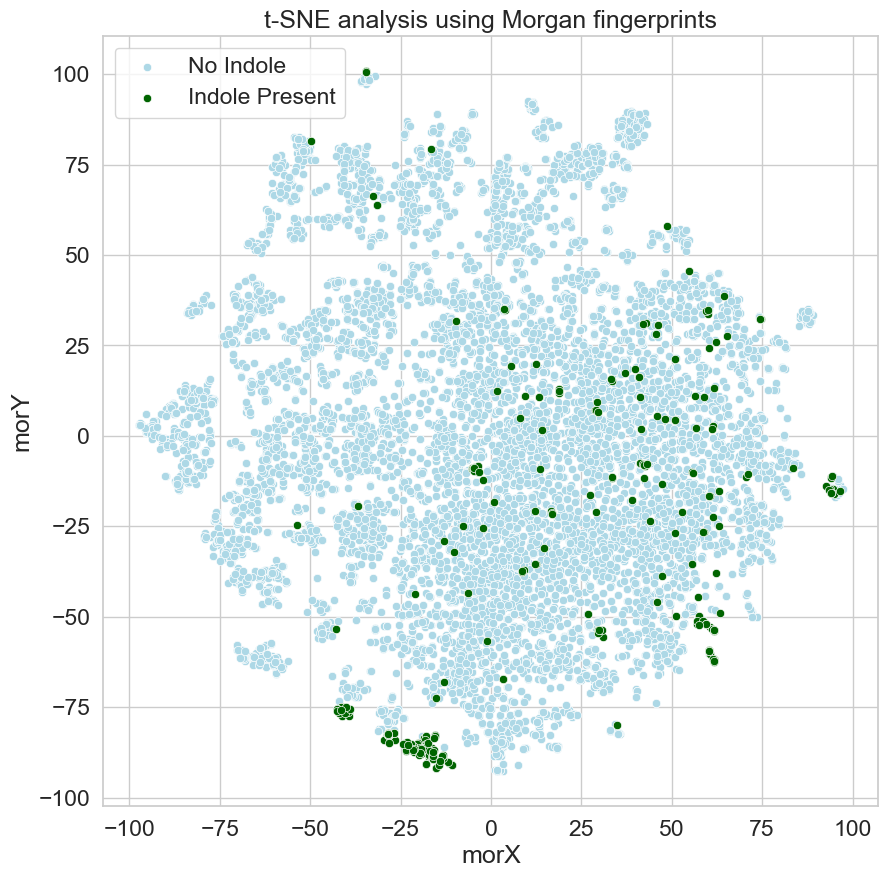

In [22]:
morax = sns.scatterplot(data=mortsne_df.query("Has_Indole == 0"),x="morX",y="morY",color='lightblue')
morax = sns.scatterplot(data=mortsne_df.query("Has_Indole == 1"),x="morX",y="morY",color='darkgreen')

# Add legend
_ = plt.legend(labels=['No Indole', 'Indole Present'])

# Add title
plt.title('t-SNE analysis using Morgan fingerprints')

Text(0.5, 1.0, 't-SNE analysis using Avalon fingerprints')

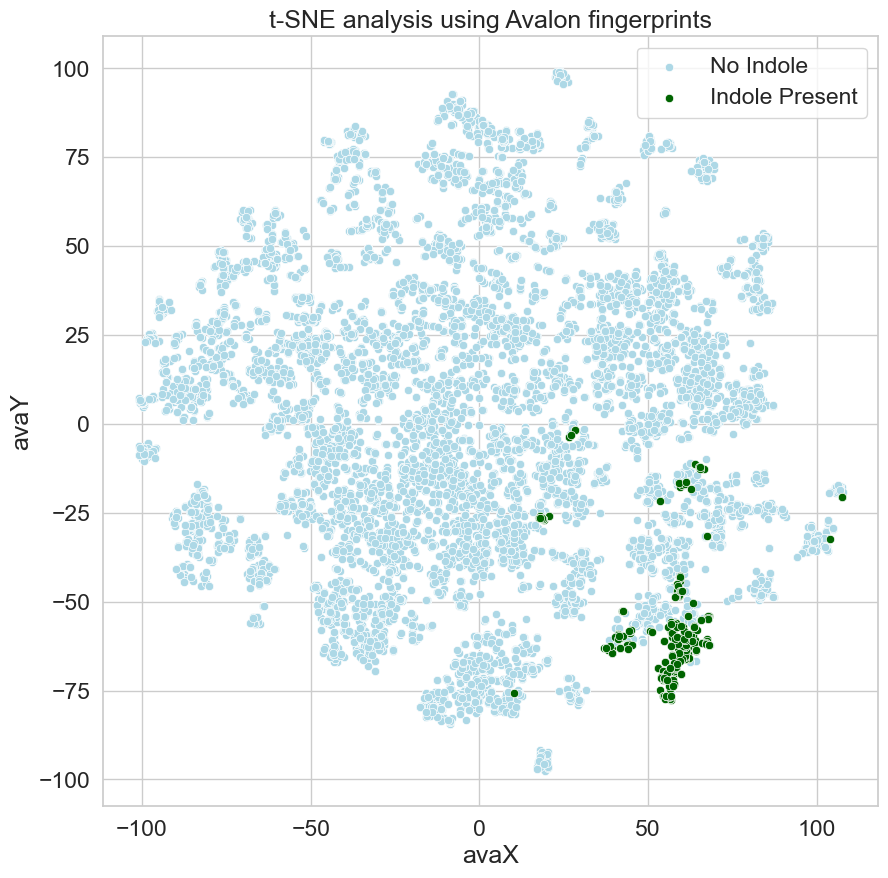

In [23]:
avaax = sns.scatterplot(data=avatsne_df.query("Has_Indole == 0"),x="avaX",y="avaY",color='lightblue')
avaax = sns.scatterplot(data=avatsne_df.query("Has_Indole == 1"),x="avaX",y="avaY",color='darkgreen')

# Add legend
_ = plt.legend(labels=['No Indole', 'Indole Present'])

# Add title
plt.title('t-SNE analysis using Avalon fingerprints')

Text(0.5, 1.0, 't-SNE analysis using Topological Torsion fingerprints')

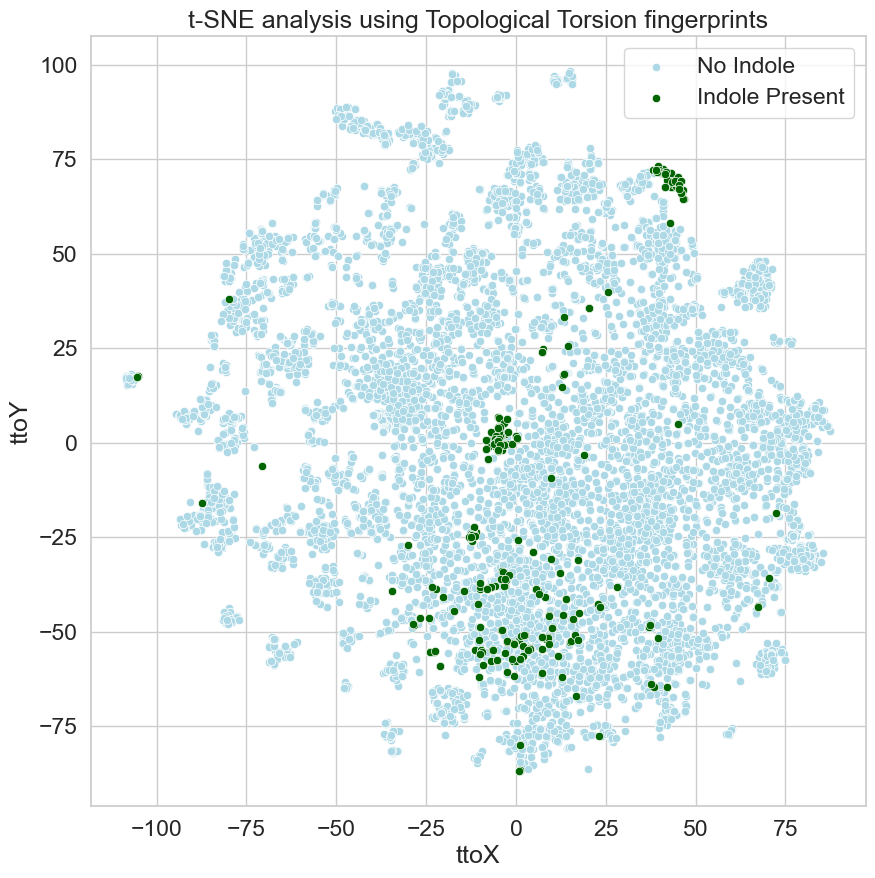

In [24]:
ttoax = sns.scatterplot(data=ttotsne_df.query("Has_Indole == 0"),x="ttoX",y="ttoY",color='lightblue')
ttoax = sns.scatterplot(data=ttotsne_df.query("Has_Indole == 1"),x="ttoX",y="ttoY",color='darkgreen')

# Add legend
_ = plt.legend(labels=['No Indole', 'Indole Present'])

# Add title
plt.title('t-SNE analysis using Topological Torsion fingerprints')

Text(0.5, 1.0, 't-SNE analysis using MACCS fingerprints')

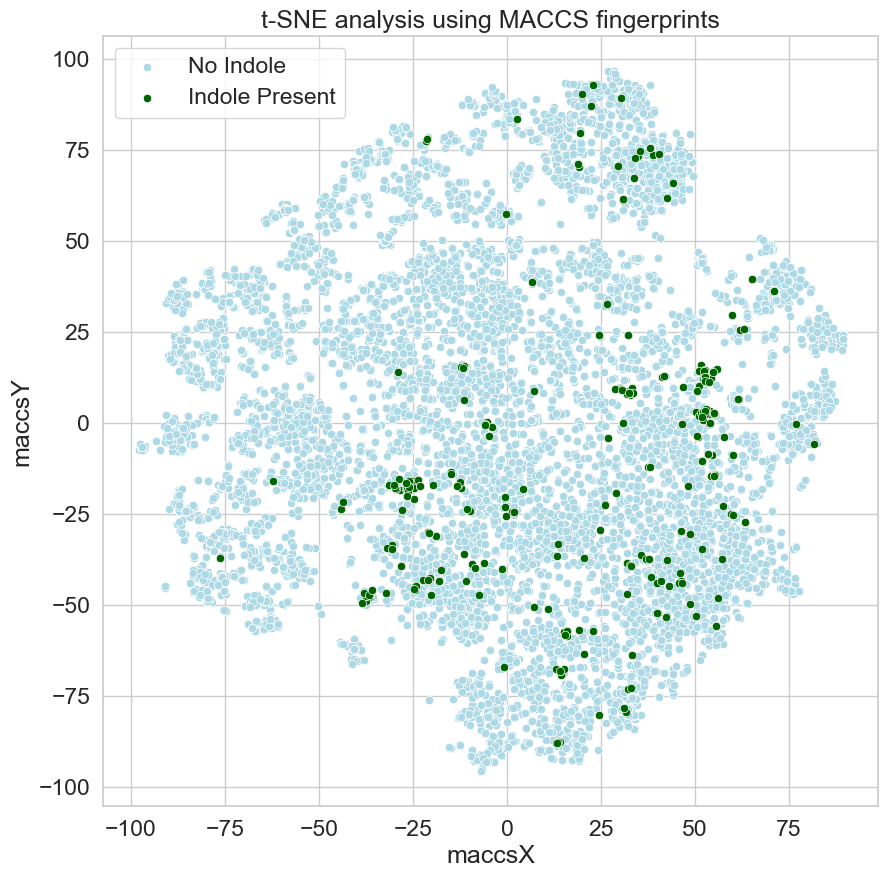

In [26]:
maccsax = sns.scatterplot(data=maccstsne_df.query("Has_Indole == 0"),x="maccsX",y="maccsY",color='lightblue')
maccsax = sns.scatterplot(data=maccstsne_df.query("Has_Indole == 1"),x="maccsX",y="maccsY",color='darkgreen')

# Add legend
_ = plt.legend(labels=['No Indole', 'Indole Present'])

# Add title
plt.title('t-SNE analysis using MACCS fingerprints')

Change perplexity.

Create a new dataframe with the data we want to save to disk. 

In [107]:
output_just_tsne_df = pd.concat([df["Name"],mortsne_df[["morX","morY"]],avatsne_df[["avaX","avaY"]],ttotsne_df[["ttoX","ttoY"]], maccstsne_df[["maccsX","maccsY"]]],axis=1)
output_just_tsne_df.head()

,Name,morPC_1,morPC_2,morX,morY,avaPC_1,avaPC_2,avaX,avaY,ttoPC_1,ttoPC_2,ttoX,ttoY,maccsPC_1,maccsPC_2,maccsX,maccsY
0,Bivalirudin,2.539088,-0.555063,-20.853830,-88.409492,0.805624,2.128606,-23.338179,25.389338,3.714470,1.728447,37.895958,68.440071,2.257830,-1.863216,53.770695,11.144918
1,Leuprolide,3.290432,0.159194,-26.087456,-88.513695,8.233128,-1.444422,51.959785,-74.103310,4.143136,2.051997,42.714577,69.180595,2.750004,-1.925191,55.901806,11.487069
2,Goserelin,3.175423,0.336041,-26.570332,-88.701363,8.922778,-0.207221,51.598835,-74.046066,3.959680,1.879855,43.038147,69.083946,3.066457,-2.156118,56.775791,12.662444
3,Gramicidin D,1.285003,-0.873331,-30.506905,-78.056374,5.426151,-0.086389,56.469410,-69.095177,2.830334,1.555354,44.601707,65.469048,0.920247,-1.057296,33.082027,9.590095
4,Desmopressin,2.396483,-0.080431,-42.266457,-70.162010,0.289790,-0.578004,-21.334366,23.306152,2.887252,0.868575,36.677002,69.585213,2.395233,-1.122772,55.517921,8.163020


Write the dataframe to a csv file.  Note that we set "index=False" to avoid writling line numbers to the csv file.

In [108]:
output_just_tsne_df.to_csv("../Metrics/dude_erk2_mk01_tnse.csv",index=False)

In [86]:
# Morgan fingerperints
morpca = PCA(n_components=50)
morcrds = morpca.fit_transform(morfp_list)

# Avalon fingerprints
avapca = PCA(n_components=50)
avacrds = morpca.fit_transform(avafp_list) 

# Topological torsion fingerprints
ttopca = PCA(n_components=50)
ttocrds = ttopca.fit_transform(ttofp_list) 

# MACCS fingerprints
maccspca = PCA(n_components=50)
maccscrds = maccspca.fit_transform(maccsfp_list) 